# **Piotroski F Score**
---
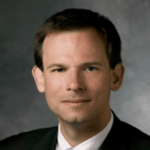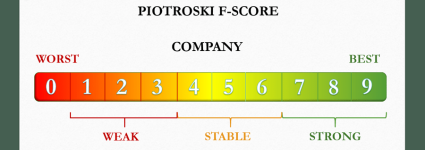


## El PIOTROSKI F SCORE, es un indicador financiero creado por Joseph Piotroski, según 9 criterios de fortaleza financiera de empresas (escala de 0 a 9). 
### Para saber más: https://finbox.com/blog/piotroski-f-score-explained/

# Instalación de librerias


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# File manipulation
from google.colab import files

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Finance related operations
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

# Carga de dataset
Cargamos el dataset a un `dataframe` de `pandas` e inmediatamente eliminamos todos las filas `NaN` que pueda llegar a tener


In [ ]:
# Subo los archivos a la notebook/colab ('financial_data.csv')

upload = files.upload()

# NOTA: si la funcion da ERROR, utilizar el "boton" de subir archivos 
# en la solapa "Archivos" o utilizar la  celda siguiente


In [ ]:
# ALTERNATIVA para subir el CSV, montar Google Drive y copiar el archivo

from google.colab import drive
drive.mount('/content/drive')

# CAMBIAR segun corresponda
!cp /content/drive/MyDrive/MentoriaDiploDatos2022/financial_data.csv ./


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset
FINANCIAL_DATASET = 'financial_data.csv' #(1ro subir el csv a Google Colab)

# Load data
input_df = pd.read_csv(FINANCIAL_DATASET)

# Drop rows with no information
input_df.dropna(how='all', inplace=True)

# Acondicionamiento del Dataset
Ponemos en condiciones el dataset para luego poder obtener el "Score"

In [ ]:
# Imprimo las columnas, para luego seleccionar las que nos ayudan a calcular el "Score"
for column in input_df.columns:
  print(input_df[column].dtype, column)


object Unnamed: 0
float64 Revenue
float64 Revenue Growth
float64 Cost of Revenue
float64 Gross Profit
float64 R&D Expenses
float64 SG&A Expense
float64 Operating Expenses
float64 Operating Income
float64 Interest Expense
float64 Earnings before Tax
float64 Income Tax Expense
float64 Net Income - Non-Controlling int
float64 Net Income - Discontinued ops
float64 Net Income
float64 Preferred Dividends
float64 Net Income Com
float64 EPS
float64 EPS Diluted
float64 Weighted Average Shs Out
float64 Weighted Average Shs Out (Dil)
float64 Dividend per Share
float64 Gross Margin
float64 EBITDA Margin
float64 EBIT Margin
float64 Profit Margin
float64 Free Cash Flow margin
float64 EBITDA
float64 EBIT
float64 Consolidated Income
float64 Earnings Before Tax Margin
float64 Net Profit Margin
float64 Cash and cash equivalents
float64 Short-term investments
float64 Cash and short-term investments
float64 Receivables
float64 Inventories
float64 Total current assets
float64 Property, Plant & Equipment Ne

Explicación del Piotroski F Score según fuente: https://finbox.com/blog/piotroski-f-score-explained/

Profitability Criteria: 
1. Net Income -> NI
2. Return on Assets -> ROA 
3. Cash Flow Operating -> CFO 
4. CFO > NI (earnings quality) -> EQ (Earnings Quality)

Leverage, Liquidity, and Source of Funds Criteria:
5. Long Term Debt Current Year < Long Term Debt Previous Year (decreasing leverage) -> LTDQ (Long Term Debt Quality)
6. Current Ratio Current Year > Current Ratio Previous Year (increasing liquidity) -> CRQ (Current Ratio Quality)
7. No new shares issued in the last year (shares dilution) -> SQ (Shares Quality)

Operating Efficiency Criteria:
8. Gross Margin Current Year > Gross Margin Previous Year -> GMQ (Gross Margin Quality)
9. Asset Turnover Ratio Current Year > Asset Turnover Ratio Previous Year -> ATRQ (Asset Turnover Ratio Quality)

In [ ]:
# Ya definimos la estructura de cada FACTOR del SCORE según explicado recién y
# cargamos los valores por defecto

default_piotroski_factors = {"NI": 0, #NetIncome
                     "ROA": 0, #Return On Assets
                     "CFO": 0, #Cash Flow Operating
                     "EQ": 0, #Earnings Quality
                     "LTDQ": 0, #Long Term Debt Quality
                     "CRQ": 0, #Current Ratio Quality
                     "SQ": 0, #Shares Quality
                     "GMQ": 0, #Gross Margin Quality
                     "ATRQ": 0, #Assets Turnover Ratio Quality
                     }

In [ ]:
# Seleccionamos las columnas basicas y las que nos ayudan a calcular el SCORE

selected_columns = [
    # Basic Columns
    "Unnamed: 0", #Ticker
    "Sector",
    "year",
    "Class",
    "AnualPriceVariation",
    # Piotroski F Score
    "Net Income",
    "returnOnAssets",
    "Operating Cash Flow",
    "Long-term debt",
    "currentRatio",
    "Total shareholders equity",
    "Gross Margin",
    "assetTurnover",
    ]

df = input_df[selected_columns]

In [ ]:
# Renombramos las columnas para mejor manejo e interpretación

renamed_columns = {
    'Unnamed: 0':'Ticker',
    'year':'Year',
    'Net Income':'NetIncome',
    'AnualPriceVariation':'AnualPriceVar',
    'returnOnAssets':'RetOnAssets',
    'Operating Cash Flow':'OpCashFlow',
    'Long-term debt':'LongTermDebt',
    'currentRatio':'CurrentRatio',
    'Total shareholders equity':'TSEquity',
    'Gross Margin':'GrossMargin',
    'assetTurnover':'AssetTurnOver',
    }

df.rename(columns=renamed_columns, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Visualizamos como quedaron los nombres y caraterísticas de las columnas finales del dataset

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 22076
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         22077 non-null  object 
 1   Sector         22077 non-null  object 
 2   Year           22077 non-null  int64  
 3   Class          22077 non-null  int64  
 4   AnualPriceVar  22077 non-null  float64
 5   NetIncome      20512 non-null  float64
 6   RetOnAssets    15542 non-null  float64
 7   OpCashFlow     20909 non-null  float64
 8   LongTermDebt   20169 non-null  float64
 9   CurrentRatio   19012 non-null  float64
 10  TSEquity       20705 non-null  float64
 11  GrossMargin    20878 non-null  float64
 12  AssetTurnOver  19933 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 2.4+ MB
None


In [ ]:
# Visualizamos algunos datos para interiorizarnos de los mismos

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', 20)
df.style.set_table_styles([{'selector':'th',
                            'props':[('word-wrap', 'break-word'),
                                     ('max-width', '20px'),
                                     ('text-align', 'left')
                                    ]
                           }])
df.head()

,Ticker,Sector,Year,Class,AnualPriceVar,NetIncome,RetOnAssets,OpCashFlow,LongTermDebt,CurrentRatio,TSEquity,GrossMargin,AssetTurnOver
0,PG,Consumer Defensive,2014,0,-9.32,"11,643,000,000.00",0.58,"13,958,000,000.00","19,811,000,000.00",0.94,"69,976,000,000.00",0.48,0.52
1,VIPS,Consumer Defensive,2014,0,-25.51,"135,822,731.68",0.04,"526,745,560.22","622,374,071.68",0.21,"412,354,536.65",0.25,1.36
2,KR,Consumer Defensive,2014,1,33.12,"1,519,000,000.00",0.10,"3,573,000,000.00","9,653,000,000.00",0.82,"5,384,000,000.00",0.21,3.36
3,RAD,Consumer Defensive,2014,1,2.75,"249,414,000.00",0.07,"702,046,000.00","5,707,969,000.00",1.71,"-2,113,702,000.00",0.29,3.68
4,GIS,Consumer Defensive,2014,1,12.90,"1,824,400,000.00",0.63,"2,541,000,000.00","6,423,500,000.00",0.81,"6,534,800,000.00",0.36,0.77


# Cálculo de tablas auxiliares
Para poder calcular los scores finales por empresa/año, tenemos que crear las tablas auxiliares que proporcionan todos los datos necesarios para alimentar a las fórmulas que componen el Piotroski F Score.
Es una depuración y recombinación de columnas del dataframe que ya poseemos.

In [ ]:
# Calculamos la tabla auxiliar con todos los años disponibles
# NOTA: borramos los registros que no tienen año, ya que es un dato fundamental

df.dropna(subset=["Year"], inplace=True)
year_df = pd.DataFrame(df["Year"].unique(), columns=['Year']).sort_values(by='Year')
year_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Year
0,2014
1,2015
2,2016
3,2017
4,2018


In [ ]:
# Creamos el dataframe con todas los Empresas por Año para luego iterar y
# calcular el SCORE de cada una

ticker_year_df = df[['Ticker', 'Year']].groupby(['Ticker', 'Year']).apply(lambda x: x)
ticker_year_df.head()

,Ticker,Year
0,PG,2014
1,VIPS,2014
2,KR,2014
3,RAD,2014
4,GIS,2014


# Funciones auxiliares para el cálculo del score

In [ ]:
# Definimos la funcion que calcula los FACTORES del Piotroski F Score

def piotroski_factors_calculation(inNI, #input Net Income
                      inROA, #input Return On Asset (current Year)
                      inCFO, #input Cash Flow Operating (current year)
                      inLTDcy, #input Long Term Debt (current year)
                      inLTDpy, #input Long Term Debt (previous year)
                      inCRcy, #input Current Ratio (current year)
                      inCRpy, #input Current Ratio (previous year)
                      inTSEcy, #input Total Shareholder Equity (current year)
                      inTSEpy, #input Total Shareholder Equity (previous year)
                      inGMcy, #input Gross Margin (current year)
                      inGMpy, #input Gross Margin (previous year)
                      inATcy, #input Asset Turnover (current year)
                      inATpy #input Asset Turnover (previous year)
                      ):
  piotroski = default_piotroski_factors.copy() #default values
  if inNI > 0: 
    piotroski["NI"] = 1
  if inROA > 0: 
    piotroski["ROA"] = 1
  if inCFO > 0:
    piotroski["CFO"] = 1
  if (inCFO != 0) and (inCFO > inNI): 
    piotroski["EQ"] = 1
  if inLTDcy < inLTDpy:
    piotroski["LTDQ"] = 1
  if inCRcy > inCRpy:
    piotroski["CRQ"] = 1
  if inTSEcy <= inTSEpy:
    piotroski["SQ"] = 1
  if inGMcy > inGMpy:
    piotroski["GMQ"] = 1
  if inATcy > inATpy:
    piotroski["ATRQ"] = 1
  return piotroski


In [ ]:
# Valor final del Piotroski F Score en base a la sumatoria de los FACTORES

def piotroski_score_calculation(piotroski_factors_dict):
  score = 0
  for key in piotroski_factors_dict:
    score += piotroski_factors_dict[key]
  return score

In [ ]:
# Creamos el dataframe final con los datos del Piotroski F Score

piotroski_dataframe_columns = {'Ticker':'', 'Year':int(), 'Sector':'', 'Class':int(), 'AnualPriceVar':float(), 'PiotroskiScore':int(),
                               'NI':int(), 'ROA':int(), 'CFO':int(), 'EQ':int(), 'LTDQ':int(), 'CRQ':int(), 'SQ':int(), 'GMQ':int(), 'ATRQ':int()
                               }
piotroski_df = pd.DataFrame(piotroski_dataframe_columns, index=[])
piotroski_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          0 non-null      object 
 1   Year            0 non-null      int64  
 2   Sector          0 non-null      object 
 3   Class           0 non-null      int64  
 4   AnualPriceVar   0 non-null      float64
 5   PiotroskiScore  0 non-null      int64  
 6   NI              0 non-null      int64  
 7   ROA             0 non-null      int64  
 8   CFO             0 non-null      int64  
 9   EQ              0 non-null      int64  
 10  LTDQ            0 non-null      int64  
 11  CRQ             0 non-null      int64  
 12  SQ              0 non-null      int64  
 13  GMQ             0 non-null      int64  
 14  ATRQ            0 non-null      int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 0.0+ bytes


# Cálculo del Piotroski F Score

In [ ]:
# Calculamos los Piotroski F Score para cada Ticker/Year

# NOTA: como el calculo requiere datos del año corriente y del año anterior,
# tenemos que saltear el primer año que tenemos en el dataframe 
# (porque no tenemos datos del año previo)

# Por cada año (salvo el primero)
for year_index, year_row in year_df.iterrows():
    if year_index == 0:
      continue
    current_year = year_row["Year"]
    previous_year = current_year - 1

    # Por cada Ticker (del año que vamos iterando) 
    for ticker_index, ticker_row in ticker_year_df.iterrows():
      if year_row["Year"] != ticker_row["Year"]:
        continue
      ticker = ticker_row["Ticker"]

      current_year_row_data_filter = (df["Year"] == current_year) & (df["Ticker"] == ticker)
      previous_year_row_data_filter = (df["Year"] == previous_year) & (df["Ticker"] == ticker)

      # Solo 1 registro de año corriente y 1 de año anterior
      # Si existen registros duplicados o hay faltantes, no se puede calcular el score y sigo de largo
      if (current_year_row_data_filter.sum() != 1) or (previous_year_row_data_filter.sum() != 1):
        continue

      current_year_row_data = df[current_year_row_data_filter].iloc[0]
      previous_year_row_data = df[previous_year_row_data_filter].iloc[0]

      piotrosky_factors = piotroski_factors_calculation(current_year_row_data["NetIncome"], #input Net Income
          current_year_row_data["RetOnAssets"], #input Return On Asset (current Year)
          current_year_row_data["OpCashFlow"], #input Cash Flow Operating (current year)
          current_year_row_data["LongTermDebt"], #input Long Term Debt (current year)
          previous_year_row_data["LongTermDebt"], #input Long Term Debt (previous year)
          current_year_row_data["LongTermDebt"], #input Current Ratio (current year)
          previous_year_row_data["LongTermDebt"], #input Current Ratio (previous year)
          current_year_row_data["TSEquity"], #input Total Shareholder Equity (current year)
          previous_year_row_data["TSEquity"], #input Total Shareholder Equity (previous year)
          current_year_row_data["GrossMargin"], #input Gross Margin (current year)
          previous_year_row_data["GrossMargin"], #input Gross Margin (previous year)
          current_year_row_data["AssetTurnOver"], #input Asset Turnover (current year)
          previous_year_row_data["AssetTurnOver"], #input Asset Turnover (previous year)
          )
      
      piotroski_score = piotroski_score_calculation(piotrosky_factors)

      final_dict_to_append_to_df = piotrosky_factors.copy()
      final_dict_to_append_to_df["Ticker"] = ticker
      final_dict_to_append_to_df["Year"] = int(current_year)
      final_dict_to_append_to_df["Sector"] = current_year_row_data["Sector"]
      final_dict_to_append_to_df["Class"] = int(current_year_row_data["Class"])
      final_dict_to_append_to_df["AnualPriceVar"] = float(current_year_row_data["AnualPriceVar"])
      final_dict_to_append_to_df["PiotroskiScore"] = int(piotroski_score)

      piotroski_df = piotroski_df.append(final_dict_to_append_to_df, ignore_index=True)
      #piotroski_df = pd.concat([piotroski_df, pd.DataFrame(final_dict_to_append_to_df)])

      print(current_year, piotroski_score, ticker)
      del final_dict_to_append_to_df


Se han truncado las últimas 5000 líneas del flujo de salida.
2017 7 GRPN
2017 5 CRM
2017 6 ATVI
2017 4 SQ
2017 3 FLEX
2017 5 XRX
2017 3 CVLT
2017 7 NVDA
2017 7 WDC
2017 7 ON
2017 4 INFY
2017 2 MFGP
2017 5 MRVL
2017 7 HPE
2017 8 TXN
2017 6 GDDY
2017 5 BOX
2017 6 AMZN
2017 6 ENTG
2017 4 CLDR
2017 4 JBL
2017 6 ACN
2017 4 ADSK
2017 5 BIDU
2017 6 IBM
2017 4 IT
2017 5 ATHM
2017 4 MOMO
2017 5 GLW
2017 7 STX
2017 7 ADBE
2017 6 CY
2017 6 TSM
2017 5 ZAYO
2017 5 ALTR
2017 6 NCR
2017 4 PSTG
2017 1 VMW
2017 7 LRCX
2017 7 NXPI
2017 7 YNDX
2017 6 GOOGL
2017 6 CGNX
2017 5 FSLR
2017 4 MX
2017 6 FTV
2017 6 BKI
2017 7 CTSH
2017 5 CTXS
2017 6 SABR
2017 5 WIT
2017 3 NTNX
2017 6 HQY
2017 2 SE
2017 6 GRUB
2017 7 NTCT
2017 7 TTWO
2017 7 KLAC
2017 4 GOOG
2017 5 PAYC
2017 5 QRVO
2017 5 DOX
2017 3 NUAN
2017 6 TEL
2017 7 EA
2017 4 GPRO
2017 4 BW
2017 6 INXN
2017 7 INFO
2017 6 YY
2017 4 NOW
2017 5 CERN
2017 5 AKAM
2017 6 CDNS
2017 4 MDRX
2017 6 LPL
2017 8 NTAP
2017 4 VIAV
2017 5 LOGM
2017 5 BB
2017 4 RUN
2017 5 YE

# Interpretación de la información

In [ ]:
# Muestro información básica del resultado (para luego sacar conclusiones)

piotroski_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17063 entries, 0 to 17062
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          17063 non-null  object 
 1   Year            17063 non-null  int64  
 2   Sector          17063 non-null  object 
 3   Class           17063 non-null  int64  
 4   AnualPriceVar   17063 non-null  float64
 5   PiotroskiScore  17063 non-null  int64  
 6   NI              17063 non-null  int64  
 7   ROA             17063 non-null  int64  
 8   CFO             17063 non-null  int64  
 9   EQ              17063 non-null  int64  
 10  LTDQ            17063 non-null  int64  
 11  CRQ             17063 non-null  int64  
 12  SQ              17063 non-null  int64  
 13  GMQ             17063 non-null  int64  
 14  ATRQ            17063 non-null  int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 2.0+ MB


In [ ]:
# Muestro información básica del resultado (para luego sacar conclusiones)

piotroski_df.describe()

,Year,Class,AnualPriceVar,PiotroskiScore,NI,ROA,CFO,EQ,LTDQ,CRQ,SQ,GMQ,ATRQ
count,"17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00","17,063.00"
mean,"2,016.57",0.57,47.58,4.52,0.62,0.44,0.74,0.79,0.34,0.38,0.36,0.39,0.46
std,1.10,0.50,"2,616.52",1.83,0.48,0.50,0.44,0.41,0.47,0.49,0.48,0.49,0.50
min,"2,015.00",0.00,-100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"2,016.00",0.00,-18.23,3.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,"2,017.00",1.00,5.65,5.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,"2,018.00",1.00,31.06,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,"2,018.00",1.00,"238,700.00",8.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


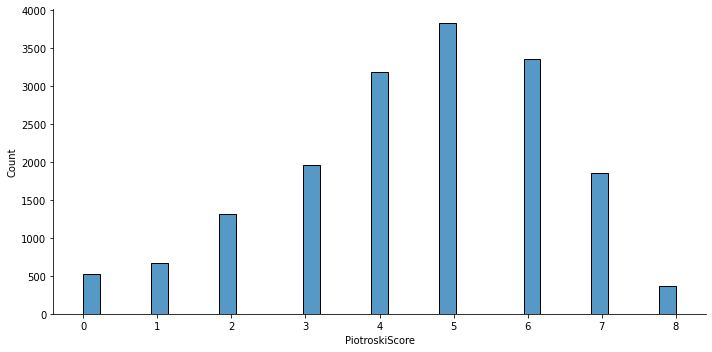

In [ ]:
# Muestro información básica del resultado (para luego sacar conclusiones)

sns.displot(piotroski_df['PiotroskiScore'], stat='count', aspect=2)


**La primera conclusión** es que ninguna empresa presenta el máximo valor del Piotroski F Score (9 puntos).

NOTA: se podría llegar a sospechar que esto se debe a que faltan datos en la tabla (NaN). Para afirmar o rechazar esta hipótesis hay que investigar más en profundidad.

NOTA 2: se investigó este tema, al final del cuaderno está la conclusión.

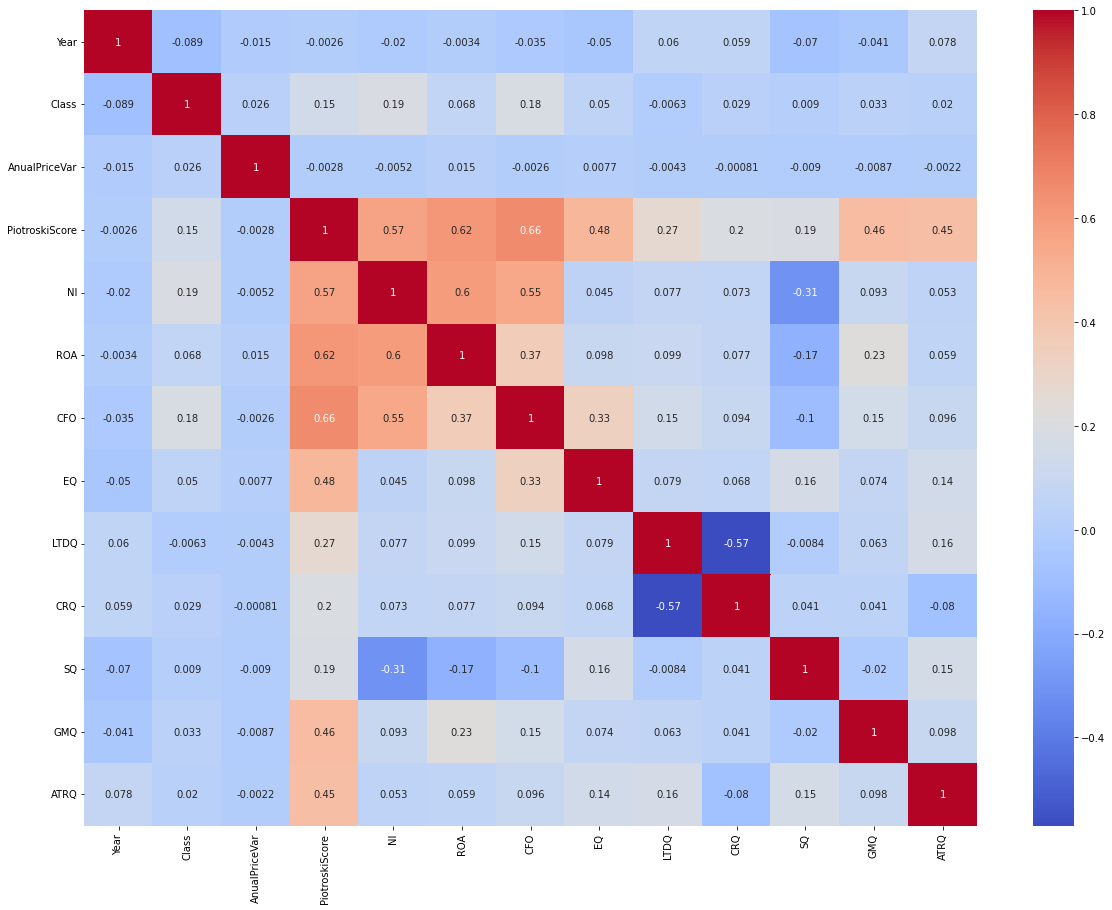

In [ ]:
# Graficamos la matriz de correlación entre los FACTORES y 
# principalmente, lo que más nos interesa es con respecto a AnualPriceVar

fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(piotroski_df.corr(), annot=True, cmap='coolwarm')
plt.show()


**La segunda conclusión** es que NO hay correlación entre el Piotroski F Score y AnualPriceVar (ni Class), o sea, que con el valor "actual" de Piotroski F Score NO podemos predecir el valor "futuro" (próximo ejercicio) de la variación del precio de las acciones.

NOTA: se podría suponer que hay valores extremos en AnualPriceVar que deforman la distribución. Esto se va a investigar a continuación.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  # This is added back by InteractiveShellApp.init_path()


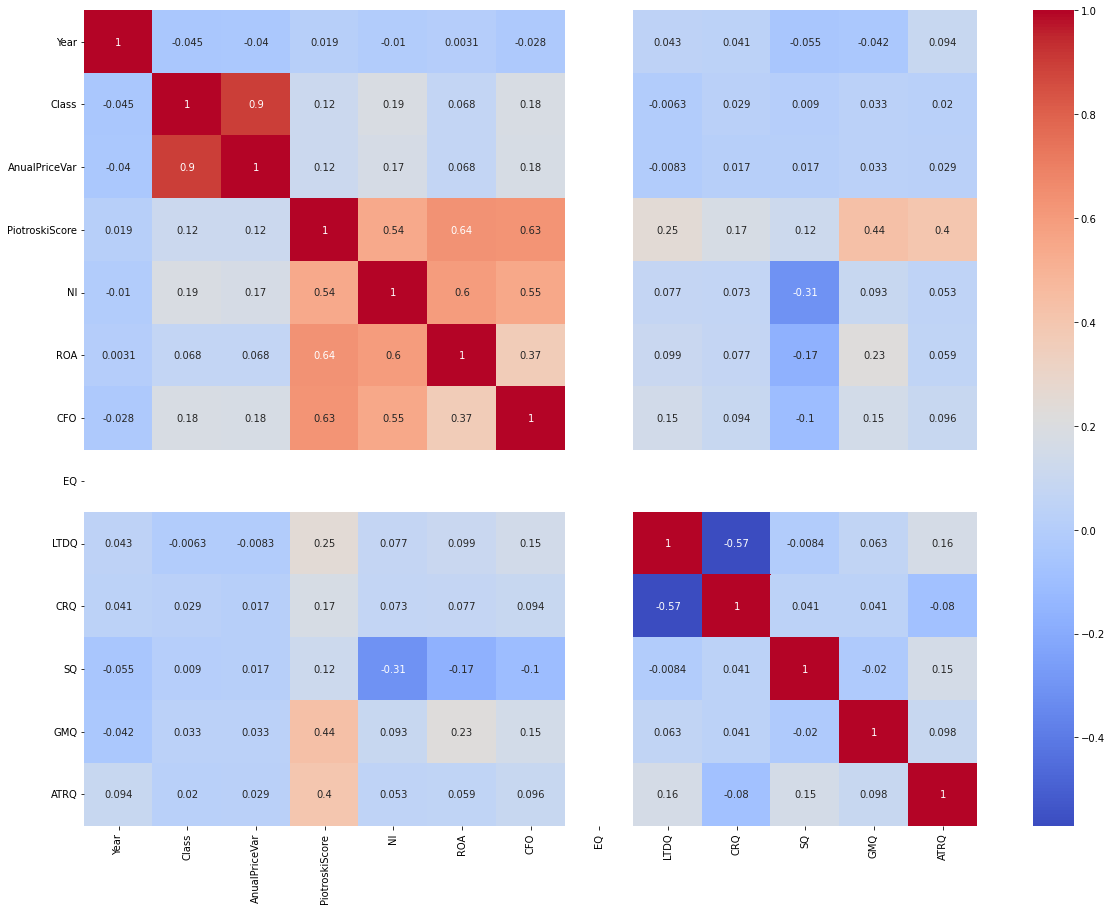

In [ ]:
# Graficamos la matriz de correlación entre los FACTORES y 
# principalmente, lo que más nos interesa es con respecto a AnualPriceVar

# Poda importante de valores extremos, solo dejamos los cuartiles centrales.
# Esto es para ver si la conclusión anterior fue afectada por valores extremos.

top_quantiles = piotroski_df.quantile(0.75)
outliers_top = (piotroski_df > top_quantiles)

low_quantiles = piotroski_df.quantile(0.25)
outliers_low = (piotroski_df < low_quantiles)

piotroski_middle_quantiles_df = piotroski_df.mask(outliers_top, top_quantiles, axis=1)
piotroski_middle_quantiles_df = piotroski_middle_quantiles_df.mask(outliers_low, low_quantiles, axis=1)

fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(piotroski_middle_quantiles_df.corr(), annot=True, cmap='coolwarm')
plt.show()

**La tercera conclusión** es que los valores extremos no cambian que NO halla correlación entre el Piotroski F Score y AnualPriceVar (ni Class).

NOTA: la columna EQ (earnings quality) no se grafica. Se investiga la razon en la celda siguiente y se pone su conclusión allí.

In [ ]:
# Investigamos la razón por la que la columna EQ (earning quality) no se graficó 
# en el mapa de correlaciónes.

# Conclusión: se verifica que todos sus valores son 1 para el rango 
# de ambos intercuartiles del medio, esto hace que su varianza sea 0 y 
# que no se pueda calcular correlaciones, es por ello que no se grafica.

piotroski_middle_quantiles_df.astype(bool).sum(axis=0)

Ticker            17063
Year              17063
Sector            17063
Class              9645
AnualPriceVar     17048
PiotroskiScore    17063
NI                10643
ROA                7447
CFO               12639
EQ                17063
LTDQ               5858
CRQ                6541
SQ                 6087
GMQ                6668
ATRQ               7798
dtype: int64

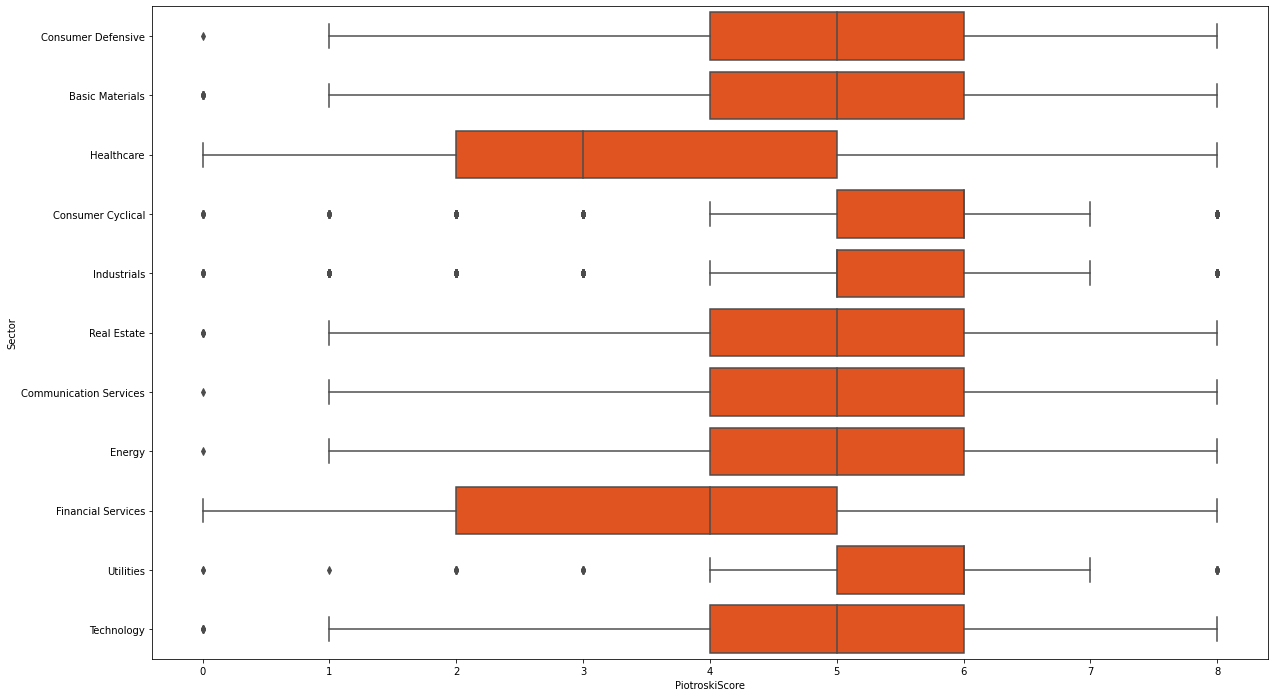

In [ ]:
# Visualizamos el SCORE por Sector

plt.figure(figsize=(20, 12))
sns.boxplot(data=piotroski_df, x='PiotroskiScore', y='Sector', color='orangered')
plt.ticklabel_format(style='plain', axis='x')

**La cuarta conclusión** es que salvo en los sectores de Servicios Financieros y Cuidado de la Salud, el Piotroski F Score se mantiene en el rango "Estable" (puntuación de 4 a 6) para los cuartiles centrales. 

En los otros sectores de la industria mencionados, la calidad baja, llegando a abarcar también el rango de la zona "Debil".

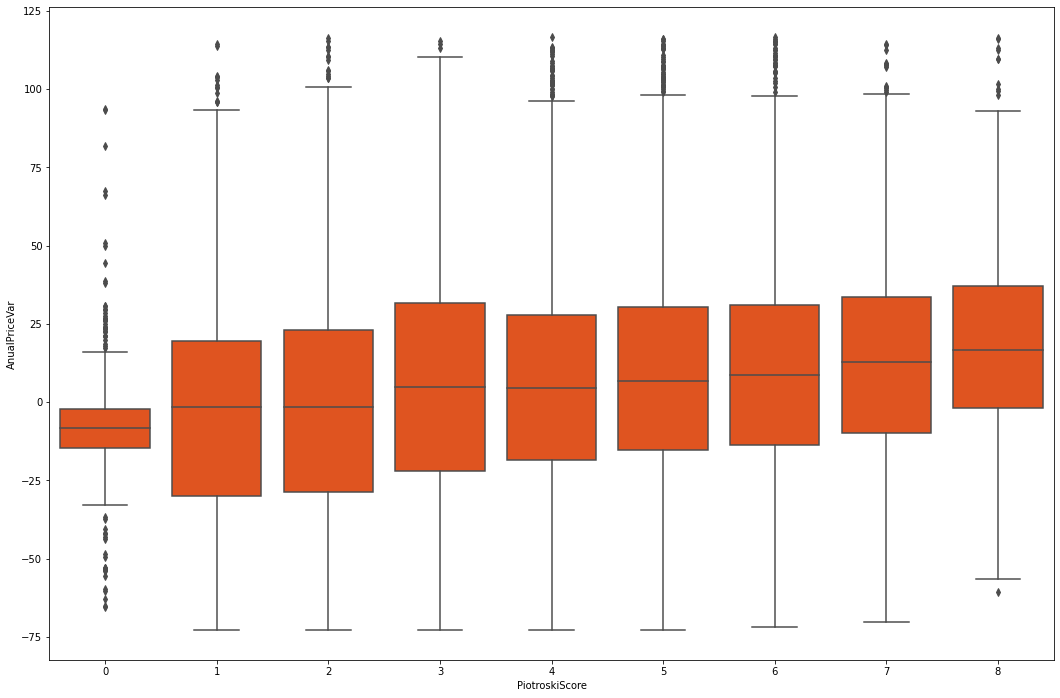

In [ ]:
# Visualizamos si existe algúna relación entre el Piotroski F Score y
# el AnualPriceVar, más allá del valor arrojado por el mapa de calor, 
# sino más detallado.

# NOTA: para ello eliminamos los valores extremos del AnualPriceVar
# eliminamos los percentiles 3% superior e inferior, que en distribución
# normal es equivalente a 2 desviaciones estandard.

top_quantiles = piotroski_df.AnualPriceVar.quantile(0.97)
low_quantiles = piotroski_df.AnualPriceVar.quantile(0.03)

piotroski_2std_df = piotroski_df[piotroski_df.AnualPriceVar.lt(top_quantiles) & piotroski_df.AnualPriceVar.gt(low_quantiles)]

plt.figure(figsize=(18, 12))
sns.boxplot(data=piotroski_2std_df, x='PiotroskiScore', y='AnualPriceVar', color='orangered')
plt.ticklabel_format(axis="y", style='plain')


**Como quinta y última conclusión**, si nos detenemos en la relación de las medianas de AnualPriceVar respecto a los puntajes del Piotroski F Score, notamos que para el Score 0, la mediana de AnualPriceVar es menor a cero, se empata con cero en el Score 1 y 2, y es mayor para el resto de los Score.

A medida que aumentan los Score, aumentan levemente las medianas de los AnualPriceVar.

In [ ]:
# POSDATA:
# Investigamos la razón de que no halla SCORE 9 (el máximo) para ninguna 

# Creamos un sub-dataset con los registros de Piotroski F Score con valor 8

piotroski_8_df = piotroski_df[piotroski_df["PiotroskiScore"] == 8]

In [ ]:
# POSDATA:
# Visualización básica de los datos

piotroski_8_df.tail()

,Ticker,Year,Sector,Class,AnualPriceVar,PiotroskiScore,NI,ROA,CFO,EQ,LTDQ,CRQ,SQ,GMQ,ATRQ
15558,RDI,2018,Consumer Cyclical,0,-23.30,8,1,1,1,1,0,1,1,1,1
15571,CPL,2018,Utilities,1,14.64,8,1,1,1,1,1,0,1,1,1
15762,IMOS,2018,Technology,1,38.64,8,1,1,1,1,0,1,1,1,1
16975,SNMP,2018,Energy,0,-84.00,8,1,1,1,1,1,0,1,1,1
17051,WTT,2018,Technology,0,-17.82,8,1,1,1,1,1,0,1,1,1


In [ ]:
# POSDATA:
# Visualizamos en que FACTOR falta el punto para el SCORE 9

# Vemos que en todos los casos o falta en EQ (earning quality) o en LTDQ (long term debt quality)
# (Se verifica que si se suman ambos da el total de registros)

piotroski_8_df.astype(bool).sum(axis=0)

Ticker            364
Year              364
Sector            364
Class             264
AnualPriceVar     364
PiotroskiScore    364
NI                364
ROA               364
CFO               364
EQ                364
LTDQ              189
CRQ               175
SQ                364
GMQ               364
ATRQ              364
dtype: int64

POSDATA: Como **sexta conclusión** adicional, observamos que el punto débil para las empresas que desean obtener el máximo SCORE (9), se encuentra en que no cumplen con uno de estos dos FACTORES: EQ (earning quality) o LTDQ (long term debt quality).